In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error, mean_squared_error
from scipy.interpolate import make_interp_spline


def sigmoid(z):
    z = np.array(z, dtype=np.float64)
    return 1 / (1 + np.exp(-z))

test_values = np.array([-2, -1, 0, 1, 2])
print("Sigmoid test:")
print(f"Input: {test_values}")
print(f"Output: {sigmoid(test_values)}")

Sigmoid test:
Input: [-2 -1  0  1  2]
Output: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]


In [ ]:
class LogisticRegressionManual:
    def __init__(self, learning_rate=0.01, n_iterations=10000, verbose=False, l1_coef=0.0, l2_coef=0.0):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features, dtype=np.float64)
        self.bias = 0.0 #start of gradient descent

        for i in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = sigmoid(linear_model)

            #computing gradient
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y)) + self.l2_coef * self.weights + self.l1_coef * np.sign(self.weights)
            db = (1/n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if self.verbose and i % 1000 == 0:
                loss = -np.mean(y*np.log(y_predicted + 1e-15) + (1-y)*np.log(1 - y_predicted + 1e-15))
                loss += self.l2_coef/2 * np.sum(self.weights**2) + self.l1_coef * np.sum(np.abs(self.weights))
                print(f"Iteration {i}, Loss: {loss:.4f}")  #print loss 

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        linear_model = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_model)   #returns P(y = 1 | X) for each sample

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def r_squared(self, X, y):
        y_pred = self.predict_proba(X)
        ll_model = np.sum(y*np.log(y_pred + 1e-15) + (1-y)*np.log(1 - y_pred + 1e-15))
        y_mean = np.mean(y)
        ll_null = np.sum(y*np.log(y_mean + 1e-15) + (1 - y)*np.log(1 - y_mean + 1e-15))
        return 1 - (ll_model / ll_null)

print("LogisticRegressionManual class defined successfully!")


LogisticRegressionManual class defined successfully!


In [ ]:
csv_file = '../30movies_dataset.csv'
df = pd.read_csv(csv_file).dropna()

print(f"\nDataset loaded from: {csv_file}")
print(f"Total records (after removing NaN): {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
# creating target variable y (Success)
mean_revenue = df['Gross Revenue (million)'].mean()
df['Success'] = (df['Gross Revenue (million)'] >= mean_revenue).astype(int)

print(f"Mean Revenue Threshold for Success: ${mean_revenue:.2f}")
print(f"Successful movies (revenue >= mean): {df['Success'].sum()} ({df['Success'].sum()/len(df)*100:.1f}%)")
print(f"Unsuccessful movies (revenue < mean): {(1-df['Success']).sum()} ({(1-df['Success']).sum()/len(df)*100:.1f}%)")

categorical_cols = ['Genre', 'Director', 'Lead Actor', 'Production Company', 
                    'Country of Origin', 'Original Language']

mappings = {}
for col in categorical_cols:
    df[col+'_id'] = df[col].astype('category').cat.codes
    mappings[col] = dict(enumerate(df[col].astype('category').cat.categories))
    print(f"{col}: {len(mappings[col])} unique values")

print("\nEncoding completed!")
print(f"Total feature columns created: {len(categorical_cols)}")


Dataset loaded from: ../30movies_dataset.csv
Total records (after removing NaN): 30

Columns: ['Title', 'Year', 'Genre', 'Director', 'Lead Actor', 'Production Company', 'Runtime (min)', 'Country of Origin', 'Original Language', 'Gross Revenue (million)', 'Success']

First few rows:
                      Title  Year                  Genre         Director  \
0  The Grand Budapest Hotel  2014           Comedy-Drama     Wes Anderson   
1                  Parasite  2019  Thriller, Dark Comedy     Bong Joon-ho   
2                      1917  2019             War, Drama       Sam Mendes   
3        Mad Max: Fury Road  2015         Action, Sci-Fi    George Miller   
4                La La Land  2016       Musical, Romance  Damien Chazelle   

      Lead Actor        Production Company  Runtime (min) Country of Origin  \
0  Ralph Fiennes  Fox Searchlight Pictures             99     USA / Germany   
1   Song Kang-ho          CJ Entertainment            132       South Korea   
2  George MacKay

In [5]:
feature_cols = ['Year', 'Runtime (min)'] + [col+'_id' for col in categorical_cols]
X = df[feature_cols].values.astype(np.float64)
y = df['Success'].values.astype(np.float64)


print(f"Feature columns: {feature_cols}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature matrix preview:")
print(X[:5])

# normalizing Year and Runtime (first two columns)
year_mean, year_std = X[:, 0].mean(), X[:, 0].std()
runtime_mean, runtime_std = X[:, 1].mean(), X[:, 1].std()

X[:, 0] = (X[:, 0] - year_mean) / (year_std + 1e-8)
X[:, 1] = (X[:, 1] - runtime_mean) / (runtime_std + 1e-8)

print(f"Year - Mean: {year_mean:.2f}, Std: {year_std:.2f}")
print(f"Runtime - Mean: {runtime_mean:.2f}, Std: {runtime_std:.2f}")
print("\nNormalized Year and Runtime (min) columns")
print(f"Normalized feature matrix preview:")
print(X[:5])


np.random.seed(42)
mask = np.random.rand(len(X)) < 0.8
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]


print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")

Feature columns: ['Year', 'Runtime (min)', 'Genre_id', 'Director_id', 'Lead Actor_id', 'Production Company_id', 'Country of Origin_id', 'Original Language_id']
Feature matrix shape: (30, 8)
Target vector shape: (30,)

Feature matrix preview:
[[2.014e+03 9.900e+01 8.000e+00 2.300e+01 1.600e+01 6.000e+00 1.100e+01
  0.000e+00]
 [2.019e+03 1.320e+02 2.400e+01 2.000e+00 2.300e+01 3.000e+00 6.000e+00
  2.000e+00]
 [2.019e+03 1.190e+02 2.500e+01 1.900e+01 7.000e+00 4.000e+00 8.000e+00
  0.000e+00]
 [2.015e+03 1.200e+02 1.000e+00 8.000e+00 2.600e+01 2.000e+01 1.000e+00
  0.000e+00]
 [2.016e+03 1.280e+02 1.400e+01 4.000e+00 1.800e+01 1.500e+01 9.000e+00
  0.000e+00]]
Year - Mean: 2016.00, Std: 6.61
Runtime - Mean: 128.37, Std: 22.31

Normalized Year and Runtime (min) columns
Normalized feature matrix preview:
[[-3.02429189e-01 -1.31608541e+00  8.00000000e+00  2.30000000e+01
   1.60000000e+01  6.00000000e+00  1.10000000e+01  0.00000000e+00]
 [ 4.53643783e-01  1.62830091e-01  2.40000000e+01  2.0

In [6]:

model = LogisticRegressionManual(   # training classifier
    learning_rate=0.01, 
    n_iterations=10000, 
    verbose=True, 
    l1_coef=0.01, 
    l2_coef=0.01
)

print("Model parameters:")
print(f"  Learning rate: {model.learning_rate}")
print(f"  Iterations: {model.n_iterations}")
print(f"  L1 coefficient (Lasso): {model.l1_coef}")
print(f"  L2 coefficient (Ridge): {model.l2_coef}")
print("\nTraining in progress...\n")

model.fit(X_train, y_train)
print("\nModel Training Complete!")


print(f"Bias: {model.bias:.4f}")
print(f"\nWeights:")
for i, col in enumerate(feature_cols):
    print(f"  {col}: {model.weights[i]:.4f}")


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


print(f"Number of predictions: {len(y_pred)}")
print(f"Predicted successes: {y_pred.sum()}")
print(f"Actual successes: {y_test.sum()}")
print(f"Probability range: {y_proba.min():.4f} to {y_proba.max():.4f}")


Model parameters:
  Learning rate: 0.01
  Iterations: 10000
  L1 coefficient (Lasso): 0.01
  L2 coefficient (Ridge): 0.01

Training in progress...

Iteration 0, Loss: 0.6944
Iteration 1000, Loss: 0.4306
Iteration 2000, Loss: 0.4169
Iteration 3000, Loss: 0.4053
Iteration 4000, Loss: 0.3951
Iteration 5000, Loss: 0.3861
Iteration 6000, Loss: 0.3782
Iteration 7000, Loss: 0.3712
Iteration 8000, Loss: 0.3648
Iteration 9000, Loss: 0.3592

Model Training Complete!
Bias: -2.9325

Weights:
  Year: 0.2492
  Runtime (min): 0.3417
  Genre_id: -0.0824
  Director_id: -0.1232
  Lead Actor_id: 0.0132
  Production Company_id: 0.0840
  Country of Origin_id: 0.3550
  Original Language_id: -0.2314
Number of predictions: 4
Predicted successes: 0
Actual successes: 2.0
Probability range: 0.0567 to 0.4206


In [11]:
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

mae = mean_absolute_error(y_test, y_proba)
mse = mean_squared_error(y_test, y_proba)
rmse = np.sqrt(mse)
r2 = model.r_squared(X_test, y_test)

print(f"MAE (Mean Absolute Error): {mae:.3f}")
print(f"MSE (Mean Squared Error): {mse:.3f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"Pseudo R² (McFadden's R²): {r2:.4f}")





Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Accuracy: 0.50
MAE (Mean Absolute Error): 0.539
MSE (Mean Squared Error): 0.402
RMSE (Root Mean Squared Error): 0.634
Pseudo R² (McFadden's R²): -0.7293


In [12]:
df_test = df.iloc[~mask].copy()
df_test['Predicted_Success'] = y_pred
df_test['Success_Probability'] = y_proba
df_test['Correct_Prediction'] = (df_test['Predicted_Success'] == df_test['Success']).astype(int)

print(f"Total test movies: {len(df_test)}")
print(f"Correct predictions: {df_test['Correct_Prediction'].sum()} ({df_test['Correct_Prediction'].mean()*100:.1f}%)")
print(f"Incorrect predictions: {(1-df_test['Correct_Prediction']).sum()} ({(1-df_test['Correct_Prediction']).mean()*100:.1f}%)")
print(f"\nSample predictions:")
print(df_test[['Title', 'Success', 'Predicted_Success', 'Success_Probability', 'Correct_Prediction']].head(10))

sorted_indices = np.argsort(y_proba)
y_sorted_proba = y_proba[sorted_indices]
y_sorted_actual = y_test[sorted_indices]

print("Sorted predictions by probability for smooth curve plotting")
print(f"Lowest probability: {y_sorted_proba[0]:.4f}")
print(f"Highest probability: {y_sorted_proba[-1]:.4f}")

Total test movies: 4
Correct predictions: 2 (50.0%)
Incorrect predictions: 2 (50.0%)

Sample predictions:
                      Title  Success  Predicted_Success  Success_Probability  \
1                  Parasite        0                  0             0.059255   
7                      Coco        1                  0             0.267546   
11            Black Panther        1                  0             0.056733   
12  The Wolf of Wall Street        0                  0             0.420623   

    Correct_Prediction  
1                    1  
7                    0  
11                   0  
12                   1  
Sorted predictions by probability for smooth curve plotting
Lowest probability: 0.0567
Highest probability: 0.4206


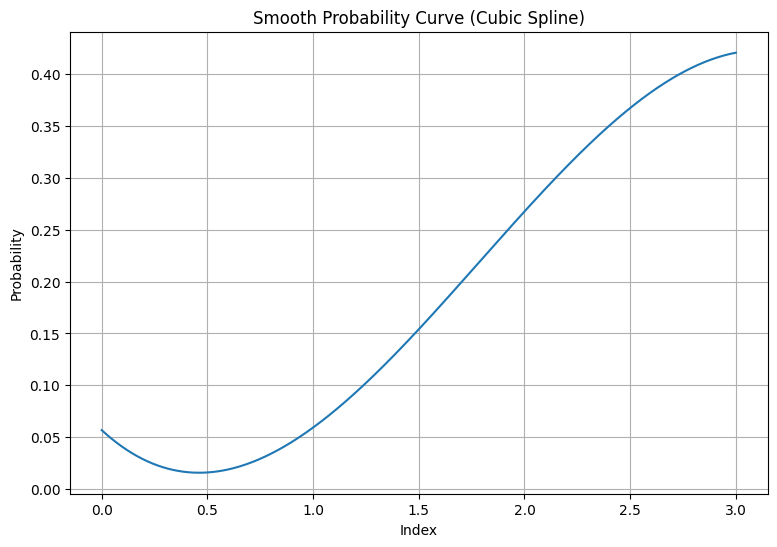

In [ ]:
x_new = np.linspace(0, len(y_sorted_proba)-1, 500)
spline = make_interp_spline(np.arange(len(y_sorted_proba)), y_sorted_proba, k=3)
y_smooth = spline(x_new)


plt.figure(figsize=(9, 6))
plt.plot(x_new, y_smooth)
plt.title("Smooth Probability Curve")
plt.xlabel("Index")
plt.ylabel("Probability")
plt.grid(True)

plt.show()

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(x_new, y_smooth, color='red', label='Predicted Probability Curve', linewidth=2)
plt.scatter(range(len(y_sorted_actual)), y_sorted_actual, color='blue', alpha=0.7, label='Actual Success')
plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Movies (sorted by predicted probability)')
plt.ylabel('Success / Probability')
plt.title('Predicted vs Actual Movie Success (Smoothed Curve)')
plt.legend()
plt.tight_layout()
plt.savefig('predicted_vs_actual_curve.png')
plt.close()


df_test.to_csv('movie_success_predictions_logistic.csv', index=False)

print("Predictions saved to 'movie_success_predictions_logistic.csv'")
print(f"\nColumns in output file:")
print(list(df_test.columns))


print("\nGenerated files:")
print("1. movie_success_predictions_logistic.csv - All predictions with probabilities")
print("2. predicted_vs_actual_curve.png - Smoothed prediction curve visualization")
print("\nModel Summary:")
print(f"  - Algorithm: Logistic Regression (Manual Implementation)")
print(f"  - Regularization: L1={model.l1_coef}, L2={model.l2_coef}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Test accuracy: {accuracy:.2%}")
print(f"  - F1 Score: {f1:.2f}")


Predictions saved to 'movie_success_predictions_logistic.csv'

Columns in output file:
['Title', 'Year', 'Genre', 'Director', 'Lead Actor', 'Production Company', 'Runtime (min)', 'Country of Origin', 'Original Language', 'Gross Revenue (million)', 'Success', 'Genre_id', 'Director_id', 'Lead Actor_id', 'Production Company_id', 'Country of Origin_id', 'Original Language_id', 'Predicted_Success', 'Success_Probability', 'Correct_Prediction']

Generated files:
1. movie_success_predictions_logistic.csv - All predictions with probabilities
2. predicted_vs_actual_curve.png - Smoothed prediction curve visualization

Model Summary:
  - Algorithm: Logistic Regression (Manual Implementation)
  - Regularization: L1=0.01, L2=0.01
  - Training samples: 26
  - Test samples: 4
  - Test accuracy: 50.00%
  - F1 Score: 0.00
